# Import module

In [131]:
import glob
import os.path
import numpy as np
import mne
import matplotlib.pyplot as plt
import pandas as pd
import yasa

plt.style.use('default')
plt.rc('font', family='Arial')
plt.rc('axes', unicode_minus=False)

mne.set_log_level('CRITICAL')

# Import data and preprocessing

In [132]:
import dataset

path_data = dataset.data_path
files = glob.glob(os.path.join(path_data, '**', 'raw.edf'), recursive=True)

In [133]:
df_info = pd.read_excel('info.xlsx', index_col=0)


In [134]:
df_power_epochs = pd.DataFrame()

for file in files:
    animal, session = np.array(file.split('\\'))[[-3, -2]]
    raw = mne.io.read_raw_edf(file, preload=True, verbose=False)
    group = df_info.loc[animal, 'Genotype']

    t = raw.times
    sf = raw.info['sfreq']

    seg_duration = 10  # seconds
    n_seg = np.floor(t.shape[0] / sf / seg_duration) - 1  # assert number of seg more than time

    raw.crop(0, seg_duration * n_seg, include_tmax=False)
    raw.set_channel_types({'Loco': 'bio'})
    raw.notch_filter(np.arange(50, 100, 50))

    eog_events = mne.preprocessing.find_eog_events(raw, ch_name='P4-M1')
    onsets = eog_events[:, 0] / raw.info["sfreq"] - 0.25
    durations = [0.5] * len(eog_events)
    descriptions = ["bad blink"] * len(eog_events)
    annot_blink = mne.Annotations(
        onsets, durations, descriptions, orig_time=raw.info["meas_date"]
    )

    thr = 3
    annot_muscle, scores_muscle = mne.preprocessing.annotate_muscle_zscore(
        raw,
        ch_type='eeg',
        threshold=thr,
        min_length_good=0.5,
        filter_freq=[110, 120],
    )

    raw.set_annotations(raw.annotations + annot_blink + annot_muscle)
    epochs = mne.make_fixed_length_epochs(raw.copy().filter(1, 40), duration=seg_duration, preload=True)
    epochs.drop_bad(flat=dict(eeg=5e-6), reject={'bio': 5e-6, 'eeg': 200e-6})

    if len(epochs) == 0:
        continue

    power_epochs = epochs.compute_psd()
    freqs = power_epochs.freqs
    band_power = pd.DataFrame()
    for power_epoch in power_epochs:
        power = power_epoch.squeeze()

        df = yasa.bandpower_from_psd(power, freqs, relative=False)
        band_power = pd.concat([band_power, df])

    band_power['Animal'] = animal
    band_power['Genotype'] = group
    df_power_epochs = pd.concat([df_power_epochs, band_power])

    # ax = plt.figure(figsize=(5, 4))
    # epochs.plot_drop_log(show=False)
    # plt.show()

    raw_clean = raw.copy()
    raw_clean.filter(1, 40)
    data = raw_clean.get_data()

    data = data.reshape(2, len(epochs.drop_log), -1)

    flag = np.ones(len(epochs.drop_log), dtype='bool')
    flag[epochs.selection] = False
    data[0, flag, :] = np.nan
    data = data.reshape(2, -1)

    raw_clean._data = data

    raw_clean.save(os.path.join(path_data, raw.filenames[0].replace('.edf', '_clean.fif')), overwrite=True)

# Check data left

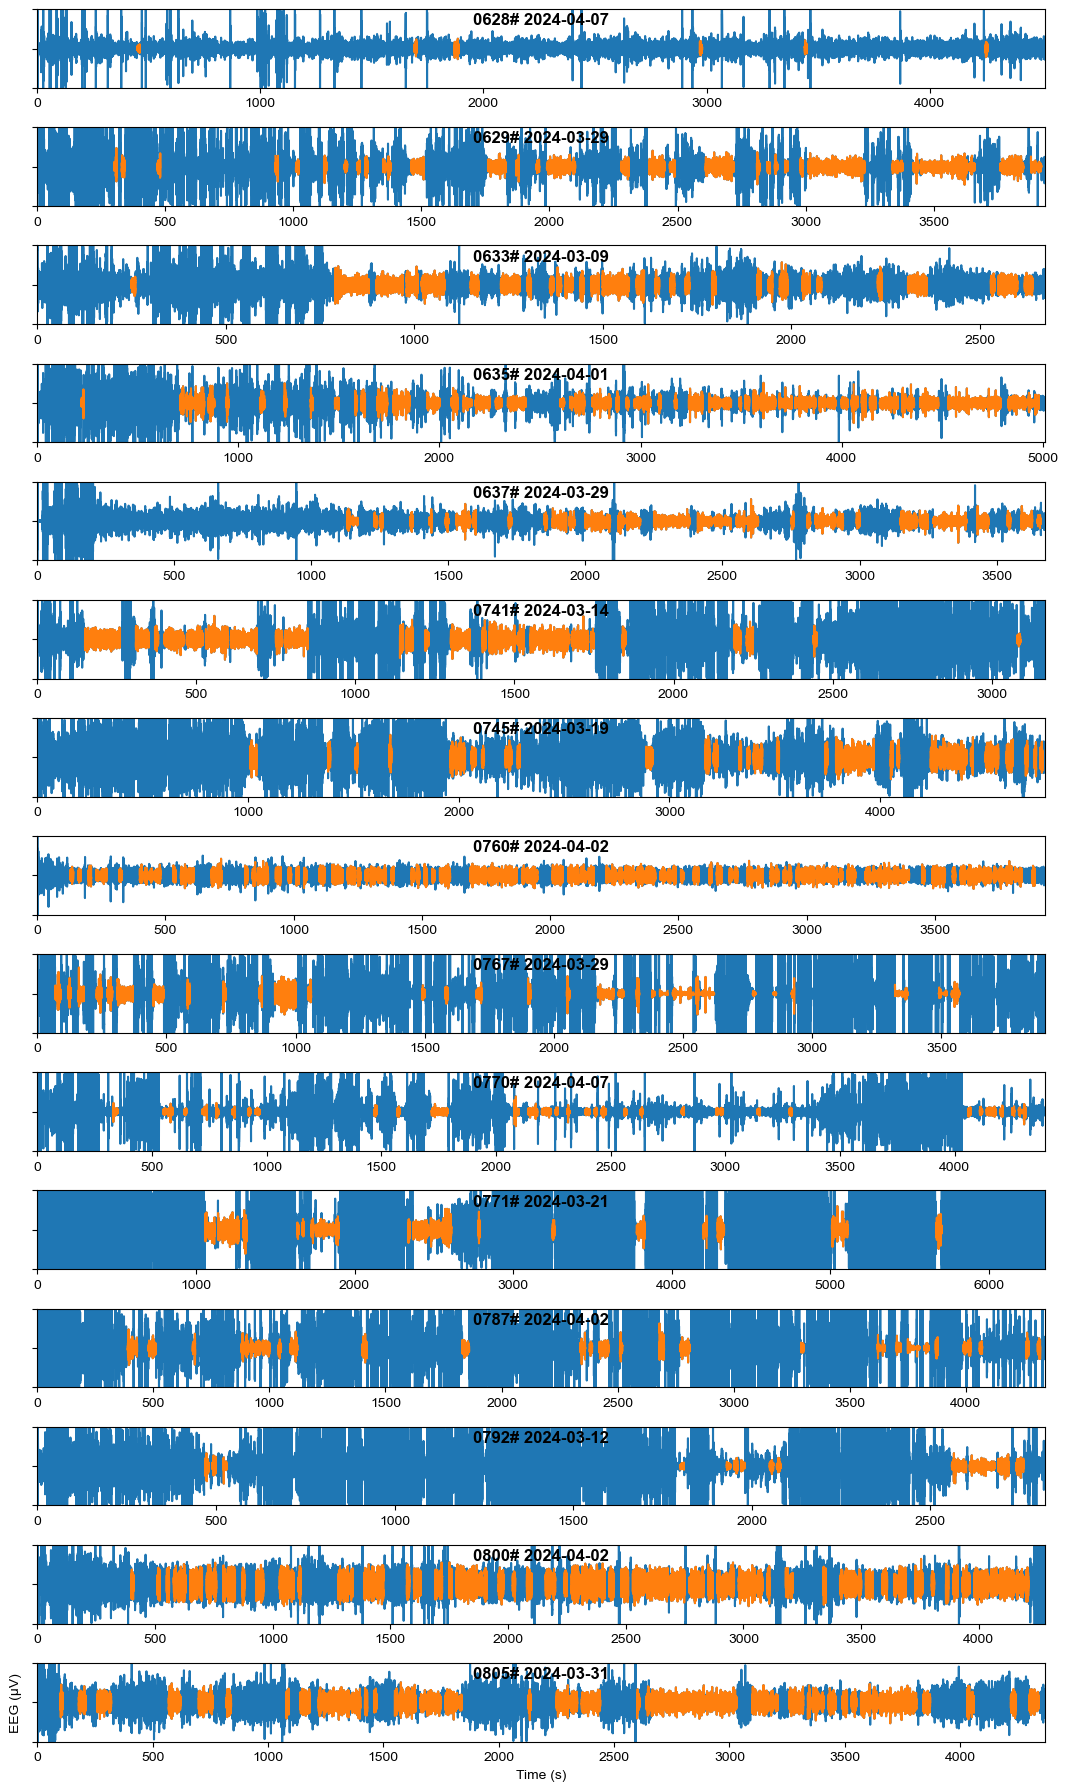

In [135]:
fig, ax_list = plt.subplots(len(files), 1, figsize=(13, 1.5 * len(files)), sharey='all', gridspec_kw={'hspace': 0.5})

for i, file in enumerate(files):
    animal, session = np.array(file.split('\\'))[[-3, -2]]

    raw = mne.io.read_raw_edf(file, preload=True)
    raw_clean = mne.io.read_raw_fif(os.path.join(path_data, raw.filenames[0].replace('.edf', '_clean.fif')))
    ax_list[i].plot(raw.times, raw.copy().filter(1, 40).pick([0]).get_data(units='uV').squeeze())
    ax_list[i].plot(raw_clean.times, raw_clean.copy().pick([0]).get_data(units='uV').squeeze())
    ax_list[i].set(

        ylim=(-200, 200),
        xlim=(raw.times[[0, -1]]),
        yticklabels=[]
    )

    ax_list[i].set_title(f'{animal} {session}', fontdict={'fontweight': 'bold'},
                         loc='center', y=0.7)

ax_list[-1].set_xlabel('Time (s)')
ax_list[-1].set_ylabel('EEG (μV)', )

plt.show()

# Plot

Data duration of 0628# in 2024-04-07 was 70.0 seconds
Data duration of 0629# in 2024-03-29 was 1210.0 seconds
Data duration of 0633# in 2024-03-09 was 750.0 seconds
Data duration of 0635# in 2024-04-01 was 2060.0 seconds
Data duration of 0637# in 2024-03-29 was 1100.0 seconds
Data duration of 0741# in 2024-03-14 was 970.0 seconds
Data duration of 0745# in 2024-03-19 was 730.0 seconds
Data duration of 0760# in 2024-04-02 was 1770.0 seconds
Data duration of 0767# in 2024-03-29 was 760.0 seconds
Data duration of 0770# in 2024-04-07 was 560.0 seconds
Data duration of 0771# in 2024-03-21 was 780.0 seconds
Data duration of 0787# in 2024-04-02 was 550.0 seconds
Data duration of 0792# in 2024-03-12 was 250.0 seconds
Data duration of 0800# in 2024-04-02 was 1670.0 seconds
Data duration of 0805# in 2024-03-31 was 1770.0 seconds


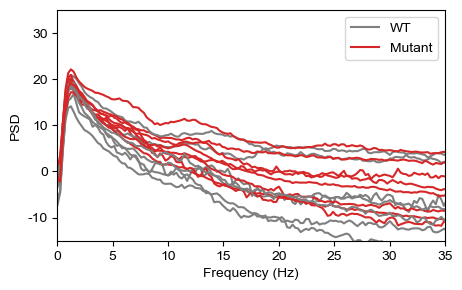

In [136]:
from scipy import signal

color_map = {
    'Mutant': 'tab:red',
    'WT': 'tab:gray'
}

bands = [
    (0.5, 4, "Delta"),
    (4, 8, "Theta"),
    (8, 12, "Alpha"),
    (12, 30, "Beta"),
]

band_names = [band[-1] for band in bands]

df_bp = pd.DataFrame()
df_data = pd.DataFrame()

_, ax = plt.subplots(figsize=(5, 3))

l = {}

for i, file in enumerate(files):

    animal = file.split('\\')[-3]
    session = file.split('\\')[-2]

    color = color_map[df_info.loc[animal, 'Genotype']]

    raw = mne.io.read_raw_edf(file, preload=True)
    raw_clean = mne.io.read_raw_fif(os.path.join(path_data, raw.filenames[0].replace('.edf', '_clean.fif')))
    eeg_cleaned = raw_clean.copy().pick(0).get_data(units='uV').squeeze()
    eeg_cleaned = eeg_cleaned[~np.isnan(eeg_cleaned)]

    if eeg_cleaned.size == 0:
        continue

    info = mne.create_info(ch_names=['EEG'], sfreq=raw.info['sfreq'], ch_types=['eeg'], verbose=False)
    raw_clean_export = mne.io.RawArray(eeg_cleaned.reshape(1, -1) / 1e6, info, verbose=False)
    raw_clean_export.export(raw.filenames[0].replace('.edf', '_clean.edf'), overwrite=True)

    df = pd.DataFrame()

    df.loc[0, 'Animal'] = animal
    df.loc[0, 'Session date'] = session
    df.loc[0, 'Genotype'] = df_info.loc[animal, 'Genotype']
    df.loc[0, 'Total data duration (s)'] = eeg_cleaned.shape[0] / sf
    print(f'Data duration of {animal} in {session} was {eeg_cleaned.shape[0] / sf} seconds')

    f, Pxx_den = signal.welch(eeg_cleaned, sf, nperseg=1024)
    Pxx_den_db = 10 * np.log10(Pxx_den)
    l[df_info.loc[animal, 'Genotype']] = ax.plot(f, Pxx_den_db, color=color, label=df_info.loc[animal, 'Genotype'])[0]
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('PSD')
    plt.xlim(0, 35)
    plt.ylim(-15, 35)

    df2 = yasa.bandpower(eeg_cleaned, sf, ch_names=['P4-M1'], bands=bands, relative=False)
    df.loc[0, band_names] = df2[band_names].to_numpy()

    df_data = pd.concat([df_data, df], ignore_index=True)

plt.legend(
    handles=list(l.values())
)
plt.show()

In [137]:
df_data = df_data.loc[df_data['Total data duration (s)'].to_numpy() > 300, :]

<Axes: xlabel='Genotype', ylabel='Total data duration (s)'>

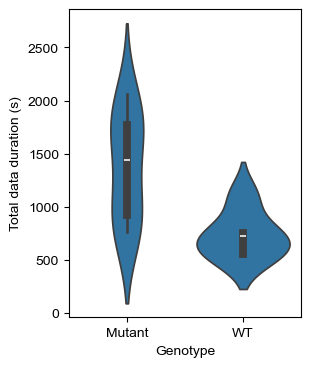

In [138]:
import seaborn as sns

plt.figure(figsize=(3, 4))
sns.violinplot(
    data=df_data,
    x='Genotype',
    y='Total data duration (s)'
)

D:\Softwares\anaconda3\envs\rsa32_in_monkeys\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


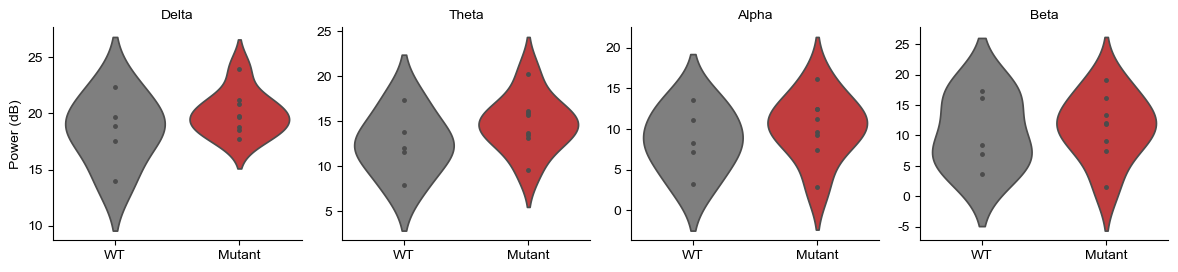

In [139]:
df_plot = df_data.melt(
    value_vars=band_names,
    value_name='Power (dB)',
    var_name='Band',
    id_vars=['Genotype'],
    ignore_index=False
)

df_plot['Power (dB)'] = 10 * np.log10(df_plot['Power (dB)'])
g = sns.FacetGrid(
    df_plot,
    col='Band',
    sharey=False,
    hue='Genotype',
    hue_order=['WT', 'Mutant'],
    palette=['tab:gray', 'tab:red']
)

g.map_dataframe(
    sns.violinplot,
    data=df_plot,
    x='Genotype',
    y='Power (dB)',
    inner="point"
)

g.set_titles('{col_name}')
g.set_xlabels('')

In [140]:
from scipy.stats import levene, ttest_ind

for band_name in band_names:
    group_A = df_plot.loc[(df_plot['Band'] == band_name) & (df_plot['Genotype'] == 'WT'), 'Power (dB)']
    group_B = df_plot.loc[(df_plot['Band'] == band_name) & (df_plot['Genotype'] == 'Mutant'), 'Power (dB)']
    _, p_square = levene(group_A, group_B)
    _, p = ttest_ind(group_A, group_B, equal_var=p_square > 0.05)

    print(f'P value in {band_name} band: {p:.2f}')


P value in Delta band: 0.29
P value in Theta band: 0.26
P value in Alpha band: 0.51
P value in Beta band: 0.81


In [141]:
df_power_epochs_plot = df_power_epochs.copy()
df_power_epochs_plot['Delta'] = 1e9 * df_power_epochs_plot['Delta']

Text(0, 0.5, 'Percent')

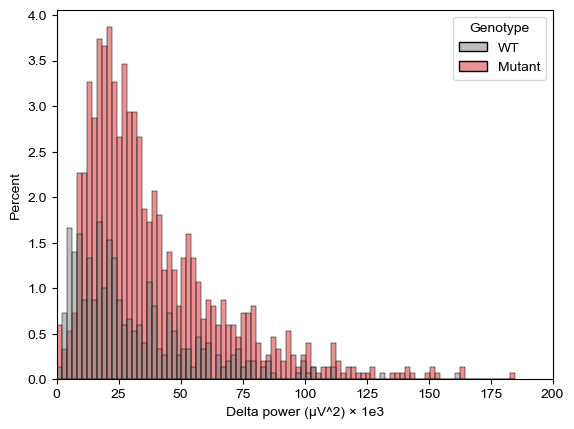

In [142]:
import seaborn as sns

sns.histplot(data=df_power_epochs_plot, x='Delta', hue='Genotype', palette=['tab:gray', 'tab:red'],
             hue_order=['WT', 'Mutant'], binwidth=2, stat='percent')
plt.xlabel('Delta power (μV^2) × 1e3')
plt.xlim(0, 200)
plt.ylabel('Percent')

In [143]:
from scipy.stats import ks_2samp

for band_name in band_names:
    group_A = df_power_epochs_plot.loc[(df_power_epochs_plot['Genotype'] == 'WT'), band_name]
    group_B = df_power_epochs_plot.loc[(df_power_epochs_plot['Genotype'] == 'Mutant'), band_name]
    res = ks_2samp(group_A, group_B)
    print(f'P value of 2 distribution in {band_name} band: {res.pvalue: .2e}')

P value of 2 distribution in Delta band:  1.86e-07
P value of 2 distribution in Theta band:  5.16e-34
P value of 2 distribution in Alpha band:  3.90e-18
P value of 2 distribution in Beta band:  6.78e-12
